In [35]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from xgboost import XGBClassifier

from results.utils import *
from preprocessing.utils import *

from huggingface_hub import hf_hub_download

import warnings
warnings.filterwarnings("ignore")

In [3]:
df_random_forest = load_results_to_dataframe('random-forest-results', 'default-of-credit-card-clients.csv')
df_random_forest = df_random_forest.dropna(axis=1, how='all')
df_random_forest

,val_accuracy,test_accuracy,train_accuracy,bootstrap,ccp_alpha,criterion,max_depth,max_features,min_impurity_decrease,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,n_estimators,oob_score,verbose,warm_start
0,0.69598,0.700143,0.998278,True,0.0,gini,None,sqrt,0.0,1,2,0.0,100,False,0,False
1,0.694305,0.683286,0.983961,False,0.0,entropy,None,0.6,0.0,5,2,0.0,757,False,0,False
2,0.688442,0.695839,0.70366,True,0.0,entropy,3,None,0.0,20,2,0.0,518,False,0,False
3,0.680905,0.682927,0.695479,True,0.0,gini,2,0.6,0.0,5,2,0.0,944,False,0,False
4,0.70938,0.710545,0.783531,False,0.0,gini,None,sqrt,0.0,23,2,0.0,2894,False,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.70268,0.682927,0.998278,False,0.0,gini,None,0.6,0.0,1,2,0.0,70,False,0,False
246,0.69598,0.702654,0.820129,False,0.0,gini,None,0.4,0.0,18,2,0.0,18,False,0,False
247,0.70603,0.7066,0.844349,True,0.0,entropy,None,0.9,0.0,11,2,0.0,2213,False,0,False
248,0.69933,0.703013,0.715178,False,0.0,gini,3,sqrt,0.0,29,2,0.0,63,False,0,False


In [4]:
df_random_forest.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250 entries, 0 to 249
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   val_accuracy              250 non-null    object
 1   test_accuracy             250 non-null    object
 2   train_accuracy            250 non-null    object
 3   bootstrap                 250 non-null    object
 4   ccp_alpha                 250 non-null    object
 5   criterion                 250 non-null    object
 6   max_depth                 72 non-null     object
 7   max_features              235 non-null    object
 8   min_impurity_decrease     250 non-null    object
 9   min_samples_leaf          250 non-null    object
 10  min_samples_split         250 non-null    object
 11  min_weight_fraction_leaf  250 non-null    object
 12  n_estimators              250 non-null    object
 13  oob_score                 250 non-null    object
 14  verbose                   250 n

In [5]:
df_random_forest[df_random_forest.columns[:3]] = df_random_forest[df_random_forest.columns[:3]].apply(pd.to_numeric)

In [6]:
for col in df_random_forest.select_dtypes(include=['object']).columns :
    print(f'Col - {col} : {df_random_forest[col].unique()}')

Col - bootstrap : [True False]
Col - ccp_alpha : [0.0]
Col - criterion : ['gini' 'entropy']
Col - max_depth : [None 3 2 4]
Col - max_features : ['sqrt' 0.6 None 0.9 0.4 0.2 0.1 0.7 0.8 'log2' 0.3]
Col - min_impurity_decrease : [0.0 0.01 0.02 0.05]
Col - min_samples_leaf : [1 5 20 23 4 2 3 22 45 11 18 37 6 17 9 25 32 29 39 40 48 24 13]
Col - min_samples_split : [2 3]
Col - min_weight_fraction_leaf : [0.0]
Col - n_estimators : [100 757 518 944 2894 108 615 1260 2717 1896 81 46 205 1780 1584 138 123
 33 1133 114 18 164 130 1157 2190 44 1785 418 315 12 84 2213 221 10 63 41
 213 441 2952 20 535 58 70 543 36 69 11 1946 779 250]
Col - oob_score : [False]
Col - verbose : [0]
Col - warm_start : [False]


In [7]:
df_random_forest.bootstrap = df_random_forest.bootstrap.astype(bool)

In [8]:
df_random_forest.min_impurity_decrease = df_random_forest.min_impurity_decrease.astype(np.float32)
df_random_forest.min_impurity_decrease.unique()

array([0.  , 0.01, 0.02, 0.05], dtype=float32)

In [9]:
df_random_forest = df_random_forest.drop(columns=['ccp_alpha'])

In [10]:
df_random_forest.min_samples_leaf = df_random_forest.min_samples_leaf.astype(np.int32)
df_random_forest.min_samples_leaf.unique()

array([ 1,  5, 20, 23,  4,  2,  3, 22, 45, 11, 18, 37,  6, 17,  9, 25, 32,
       29, 39, 40, 48, 24, 13])

In [11]:
df_random_forest.min_samples_split = df_random_forest.min_samples_split.astype(np.int32)
df_random_forest.min_samples_split.unique()

array([2, 3])

In [12]:
df_random_forest = df_random_forest.drop(columns=['min_weight_fraction_leaf'])

In [13]:
df_random_forest.n_estimators = df_random_forest.n_estimators.astype(np.int32)
df_random_forest.n_estimators.unique()

array([ 100,  757,  518,  944, 2894,  108,  615, 1260, 2717, 1896,   81,
         46,  205, 1780, 1584,  138,  123,   33, 1133,  114,   18,  164,
        130, 1157, 2190,   44, 1785,  418,  315,   12,   84, 2213,  221,
         10,   63,   41,  213,  441, 2952,   20,  535,   58,   70,  543,
         36,   69,   11, 1946,  779,  250])

In [14]:
df_random_forest = df_random_forest.drop(columns=['oob_score', 'verbose', 'warm_start'])

In [15]:
df_random_forest_1h_encoded = pd.get_dummies(df_random_forest)
df_random_forest_1h_encoded

,val_accuracy,test_accuracy,train_accuracy,bootstrap,min_impurity_decrease,min_samples_leaf,min_samples_split,n_estimators,criterion_entropy,criterion_gini,...,max_features_0.1,max_features_0.2,max_features_0.3,max_features_0.4,max_features_0.6,max_features_0.7,max_features_0.8,max_features_0.9,max_features_log2,max_features_sqrt
0,0.695980,0.700143,0.998278,True,0.0,1,2,100,False,True,...,False,False,False,False,False,False,False,False,False,True
1,0.694305,0.683286,0.983961,False,0.0,5,2,757,True,False,...,False,False,False,False,True,False,False,False,False,False
2,0.688442,0.695839,0.703660,True,0.0,20,2,518,True,False,...,False,False,False,False,False,False,False,False,False,False
3,0.680905,0.682927,0.695479,True,0.0,5,2,944,False,True,...,False,False,False,False,True,False,False,False,False,False
4,0.709380,0.710545,0.783531,False,0.0,23,2,2894,False,True,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.702680,0.682927,0.998278,False,0.0,1,2,70,False,True,...,False,False,False,False,True,False,False,False,False,False
246,0.695980,0.702654,0.820129,False,0.0,18,2,18,False,True,...,False,False,False,True,False,False,False,False,False,False
247,0.706030,0.706600,0.844349,True,0.0,11,2,2213,True,False,...,False,False,False,False,False,False,False,True,False,False
248,0.699330,0.703013,0.715178,False,0.0,29,2,63,False,True,...,False,False,False,False,False,False,False,False,False,True


In [16]:
model = LinearRegression()
model.fit(df_random_forest_1h_encoded.iloc[:, 3:], df_random_forest_1h_encoded.iloc[:, 0])

coefficients = model.coef_

# Normalize coefficients
max_abs_coefficient = np.max(np.abs(coefficients))
normalized_coefficients = coefficients / max_abs_coefficient

# Create DataFrame for normalized coefficients
feature_importance_df = pd.DataFrame({'Feature': df_random_forest_1h_encoded.columns[3:], 'Importance': np.abs(normalized_coefficients)})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df = feature_importance_df

In [17]:
feature_importance_df

,Feature,Importance
1,min_impurity_decrease,1.000000
10,max_features_0.1,0.069099
7,max_depth_2,0.067607
19,max_features_sqrt,0.046136
11,max_features_0.2,0.045511
16,max_features_0.8,0.037027
9,max_depth_4,0.035385
17,max_features_0.9,0.031808
18,max_features_log2,0.028206
12,max_features_0.3,0.020256


Text(0, 0.5, 'Feature')

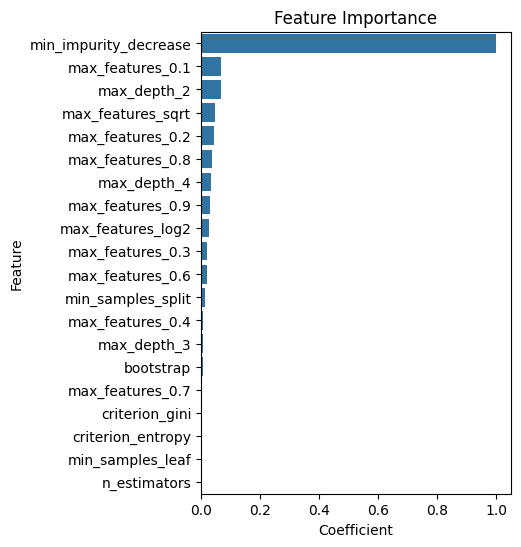

In [18]:
plt.figure(figsize=(4, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.xlabel('Coefficient')
plt.ylabel('Feature')

In [19]:
df_random_forest['test_accuracy'].max()

0.7152080344332855

In [20]:
df_random_forest['test_accuracy'].argmax()

88

In [21]:
best_hpt = df_random_forest.iloc[88, 3:].to_dict()
best_hpt

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 0.3,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 39,
 'min_samples_split': 2,
 'n_estimators': 213}

In [22]:
REPO_ID = "inria-soda/tabular-benchmark"
np.random.seed(42)

df = pd.read_csv(
    hf_hub_download(repo_id=REPO_ID, filename=f'clf_cat/default-of-credit-card-clients.csv', repo_type="dataset")
)
X, y = df.iloc[:, :-1], df.iloc[:, -1]
X, y = preprocess_data(X, y, isCategorical=True)
(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(X, y, isCategorical=True)

Removed 0 rows with missing values on 13272 rows
Removed 0 columns with missing values on 21 columns
Removed 0 rows with missing values on 13272 rows
Removed 1 columns with pseudo-categorical values on 21 columns
high cardinality columns: Index([], dtype='object')
Removed 0 high-cardinality categorical features


In [23]:
rfc = RandomForestClassifier(**best_hpt)
rfc.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_features=0.3,
                       min_samples_leaf=39, n_estimators=213)

In [ ]:
y_pred = rfc.predict(X_test)

In [38]:
(y_test == y_pred).mean()

0.7263271162123386

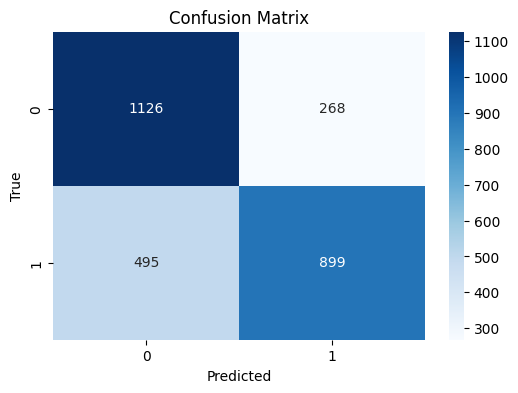

In [24]:
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Best Threshold=0.523197, G-Mean=0.720


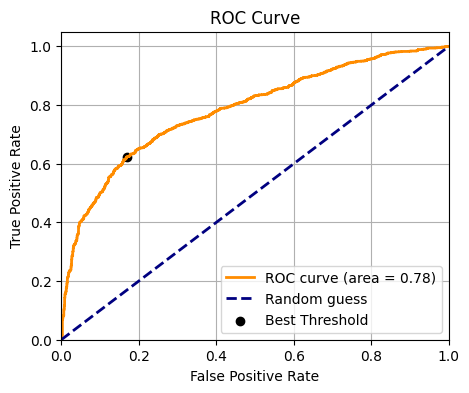

In [41]:
y_pred_prob = rfc.predict_proba(X_test)
y_prob = y_pred_prob [:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

ix = np.argmax(tpr - fpr)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

# Plot ROC curve
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guess')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [42]:
thresholds[ix]

0.5231969792144807

In [43]:
new_y_pred = (y_pred_prob > thresholds[ix]).argmax(axis=1)
new_y_pred

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [44]:
(new_y_pred == y_test).mean()

0.7270444763271162